# Extracting historical climate (rainfall) data over selected basins

* **Products used:** 
ERA5

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.load_era5 import load_era5


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Analysis Parameters

## Retrieve historical rainfall data over all areas of interest

This data has already been retrieved from ERA5 so we can simply pull in the csv on disk

In [2]:
upstream_rainfall = 'results/upstream_rainfall_daily_1989-01_to_2009-12.csv'
upstream_rainfall = pd.read_csv(upstream_rainfall, index_col='time',parse_dates=True)
upstream_rainfall.head()

,cumulative daily rainfall (mm)
time,
1989-01-01,3.232178
1989-01-02,4.107727
1989-01-03,2.748047
1989-01-04,0.680115
1989-01-05,0.550232


#### Code block that loads rainfall from ERA5

In [3]:
# # Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f
# vector_file = 'data/OB_FWR_Hydrography_Okavango_Subasins_polygon.geojson'

# # define time period of interest
# time_range = '1989-01', '2009-12'

# # load basin polygons
# # Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f-caee3d756da9
# basin = gpd.read_file(vector_file)

# # upstream include Cuito and Cubango subbasins
# upstream = basin[basin.Subbasin.isin(['Cuito', 'Cubango'])]
# print(upstream)

# # get historical rainfall for upstream and delta
# bounds = upstream.total_bounds
# lat = bounds[1], bounds[3]
# lon = bounds[0], bounds[2]

# # download ERA5 rainfall and aggregate to monthly
# var = 'precipitation_amount_1hour_Accumulation'
# precip = load_era5(var, lat, lon, time_range, reduce_func=np.sum, resample='1D').compute()

# # fix inconsistency in axis names
# precip = precip.rename({'lat':'latitude', 'lon':'longitude'})

# upstream_raster = xr_rasterize(upstream, precip, x_dim='longitude', y_dim='latitude')

# upstream_rainfall = precip[var].where(upstream_raster).sum(['latitude','longitude'])

# upstream_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'precipitation_amount_1hour_Accumulation':'cumulative daily rainfall (mm)'},axis=1).to_csv(f'results/upstream_rainfall_daily_{time_range[0]}_to_{time_range[1]}.csv')

### Plot daily rainfall

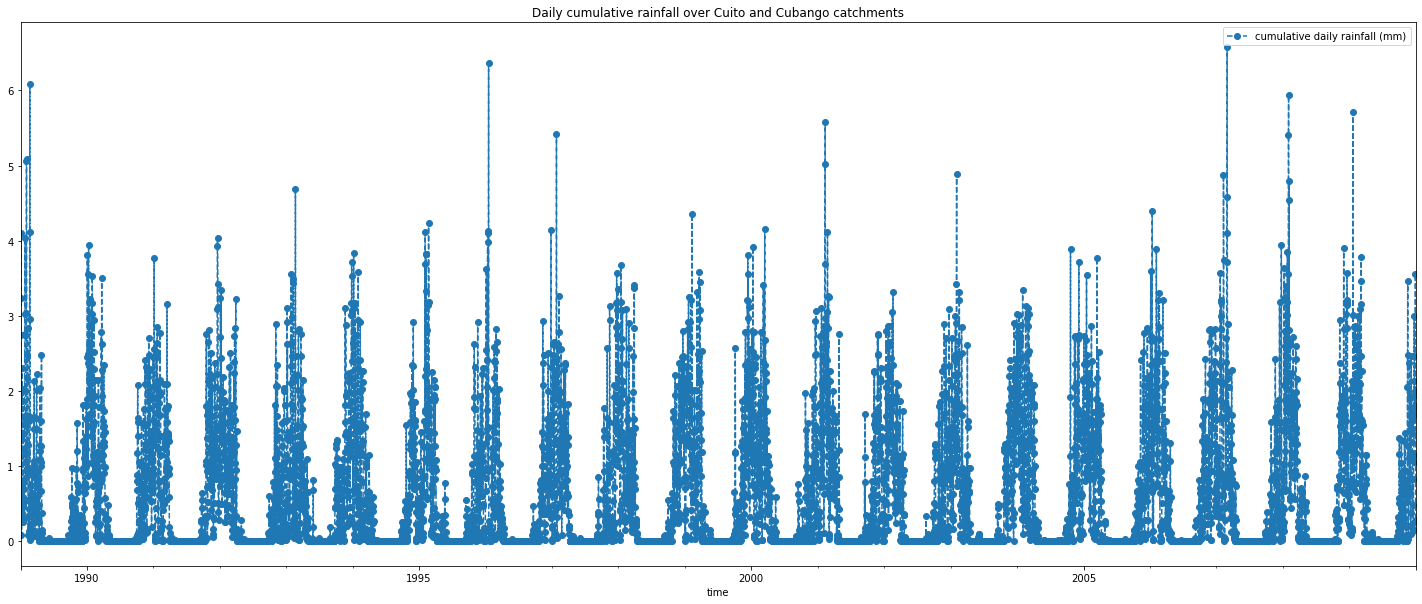

In [4]:
upstream_rainfall.plot(figsize=(25,10), marker='o', linestyle='dashed')
plt.title('Daily cumulative rainfall over Cuito and Cubango catchments');

## Import discharge data

In [5]:
discharge = 'data/mohembo_daily_water_discharge_data.csv'
dis=pd.read_csv(discharge)
dis['date'] = pd.to_datetime(dis['date'], dayfirst=True)
dis = dis.set_index('date')

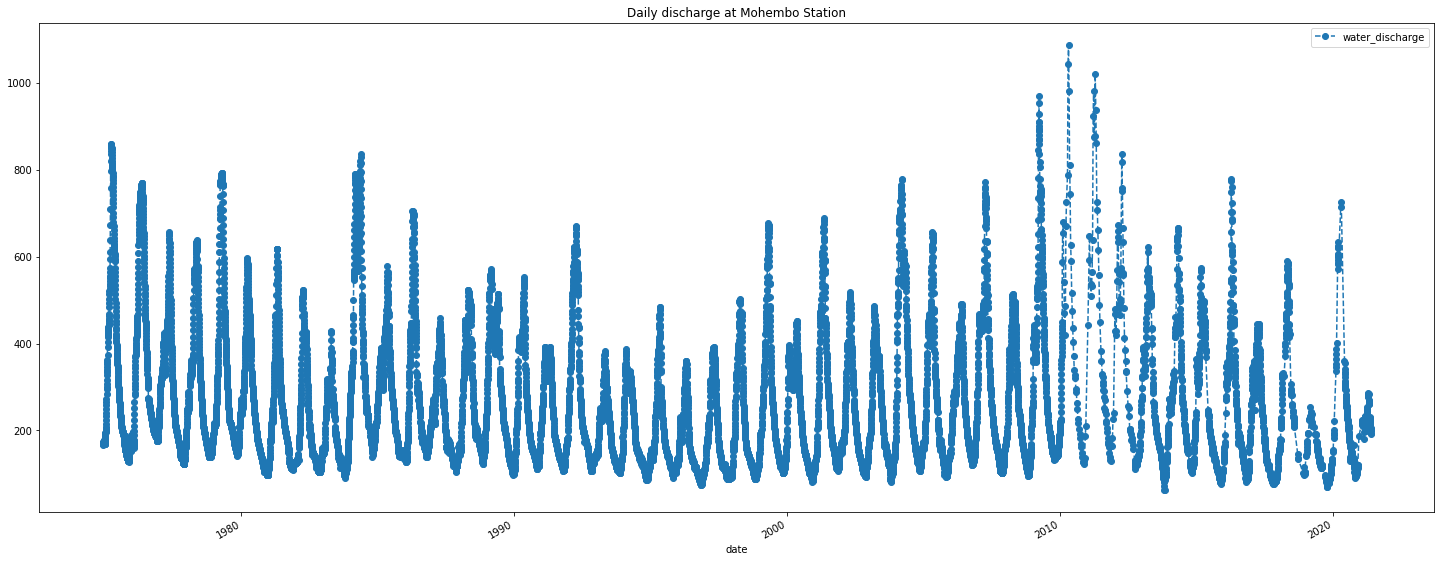

In [6]:
dis.plot(figsize=(25,10),  marker='o', linestyle='dashed')
plt.title('Daily discharge at Mohembo Station');

## Define a model between rainfall and discharge at Mohembo

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

In [8]:
max_lags = 6

### Match discharge with rainfall

Can set lags with `df.shift(1)`

In [9]:
df = upstream_rainfall.join(dis, how='inner')
df.head()

,cumulative daily rainfall (mm),water_discharge
1989-01-01,3.232178,265.93
1989-01-02,4.107727,274.26
1989-01-03,2.748047,286.54
1989-01-04,0.680115,295.05
1989-01-05,0.550232,305.53


### Resample to monthly cumulative totals

This will help with identifying the best time lag

In [10]:
freq='M'

In [11]:
#total rainfall per month
df = df.resample(freq).sum()
df.head()

,cumulative daily rainfall (mm),water_discharge
1989-01-31,45.216431,11713.97
1989-02-28,46.583008,15470.90
1989-03-31,22.774780,14089.42
1989-04-30,22.132874,12032.10
1989-05-31,0.052734,14698.84


### Lagged correlation

In [12]:
def crosscorr(datay, datax, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datay.corr(datax.shift(lag))

### Try a linear model using lagged rainfall

Correlations at each lag: [0.013, 0.48, 0.777, 0.821, 0.666, 0.33]


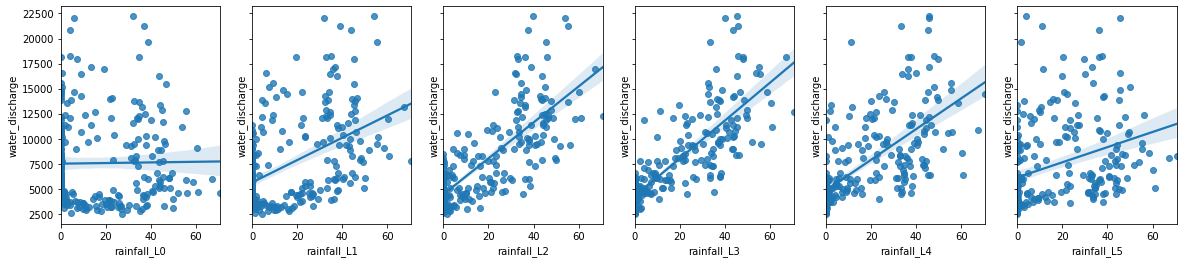

In [13]:
xcov_weekly = [crosscorr(df['water_discharge'], df['cumulative daily rainfall (mm)'], lag=i) for i in range(max_lags)]
print('Correlations at each lag:', [round(i,3) for i in xcov_weekly])

fig, ax = plt.subplots(1,max_lags, figsize=(20,4), sharey=True)
for lag in range(max_lags):
    xcovlag = np.argmax(xcov_weekly)
    df['rainfall_L'+str(lag)] = df['cumulative daily rainfall (mm)'].shift(lag)
    sns.regplot(x='rainfall_L'+str(lag), y='water_discharge', data=df, ax=ax[lag]);
    

### Try an ARIMA model

In [14]:
p=5
d=1
q=0

In [15]:
model = ARIMA(endog=df['water_discharge'], exog=df['cumulative daily rainfall (mm)'], order=(p, d, q))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        water_discharge   No. Observations:                  252
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2270.509
Date:                Tue, 03 Aug 2021   AIC                           4555.018
Time:                        22:36:55   BIC                           4579.696
Sample:                    01-31-1989   HQIC                          4564.949
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
cumulative daily rainfall (mm)   -47.9627      8.058     -5.952      0.000     -63.756     -32.169
ar.L1                              0.4383      0.050      8.775      0.000       0.340       0.536
ar.L2                             -0.0725      0.051     -1.413      0.158      -0.173       0.028
ar.L3                             -0.1228      0.059     -2.085      0.037      -0.238      -0.007
ar.L4                              0.0382      0.074      0.513      0.608      -0.108       0.184
ar.L5                             -0.3167      0.082     -3.856      0.000      -0.478      -0.156
sigma2                           4.19e+06   2.77e+05     15.099      0.000    3.65e+06    4.73e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):               121.65
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot the residuals of the model

                  0
count    252.000000
mean      41.086877
std     2232.721637
min    -7225.007116
25%    -1025.064100
50%      -12.721377
75%     1079.389135
max    13882.673493


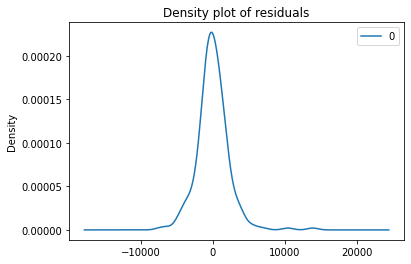

In [16]:
residuals = pd.DataFrame(fit.resid)
print(residuals.describe())
residuals.plot(kind='kde')
plt.title('Density plot of residuals');

In [17]:
fc_len = 3
fc = fit.forecast(steps=fc_len, exog=df['cumulative daily rainfall (mm)'][-fc_len:], alpha=0.05)

<AxesSubplot:>

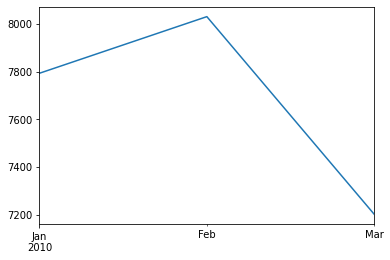

In [18]:
# dis_m = dis.resample('M').sum()
# dis_m[(dis_m.index >= pd.to_datetime('2010-01-01')) & (dis_m.index <= pd.to_datetime('2010-07-01'))].plot()
fc.plot()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.4.dev193+g3997b90f


**Last Tested:**

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-08-03'